# RNNs and LSTMs (Solutions):




#### A few imports and functions before we get started

In [ ]:
!pip install pycm livelossplot
%pylab inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import random
# import time
import math
# from joblib import load
# import glob
# import string
# import unicodedata
# import re
# from collections import Counter
from tqdm import tqdm
from sklearn.metrics import mean_squared_error as mse
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

Cuda installed! Running on GPU!
NVIDIA A100-SXM4-40GB


#### Mounting the google drive for storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Creating a custom TensorDataset that allows us to perform the following:
- Take as inputs a list of all words in our text
- Generate a dictionary of all unique words and their counts, sorted in descending order
- Return a sample of input and output data

In [ ]:
#load the model and obs
train = np.load('/content/gdrive/MyDrive/BigData/assessment/Ferguson_fire_train.npy')
print(f"Before reshaping: {np.shape(train)}")

Before reshaping: (12500, 256, 256)


In [ ]:
test = np.load('/content/gdrive/MyDrive/BigData/assessment/Ferguson_fire_test.npy')
print(f"Before reshaping: {np.shape(test)}")


Before reshaping: (5000, 256, 256)


In [ ]:
#as the fire is not consistent
class MyDataset(TensorDataset):
    def __init__(self, data,sequence_length=4):
        self.data = data.astype('float64')
        self.sequence_length = sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.data[idx:idx+self.sequence_length])       # get a sample input sequence
        sample_output = torch.tensor(self.data[idx+1:idx+self.sequence_length+1])  # get a sample output sequence

        # return sample_input.type('torch.DoubleTensor'), sample_output.type('torch.DoubleTensor')
        return sample_input[:,None,:], sample_output[:,None,:]
    
    def __len__(self):
        return len(self.data) - self.sequence_length

In [ ]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.h2x = nn.Conv2d(self.hidden_dim[0],1,1)

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        # if not self.return_all_layers:
        #     layer_output_list = layer_output_list[-1:]
        #     last_state_list = last_state_list[-1:]
        print(self.hidden_dim[0])
        h = nn.BatchNorm2d(self.hidden_dim[0])(h)
        res = self.h2x(h)
        

        return res

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
words_dataset = MyDataset(train, sequence_length=4)
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)

print(len(next(iter(words_dataloader))))
print(next(iter(words_dataloader))[0].shape)

2
torch.Size([5, 4, 1, 256, 256])


In [ ]:
test_dataset = MyDataset(test, sequence_length=4)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
print(len(next(iter(test_dataloader))))
print(next(iter(test_dataloader))[0].shape)

2
torch.Size([1, 4, 1, 256, 256])


In [ ]:
# class LSTMCell(nn.Module):

#     def __init__(self, input_size, hidden_size, bias=True):
#         super(LSTMCell, self).__init__()

#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.bias = bias

#         # we will streamline the implementation of the LSTM by combining the
#         # weights for all 4 operations (input gate, forget gate, output gate, candidate update)
#         self.i2h = nn.Linear(input_size, hidden_size * 4, bias=bias)       # create a linear layer to map from input to hidden space, *4 as he chunks to 4 gate in line 26
#         self.h2h = nn.Linear(hidden_size, hidden_size * 4, bias=bias)      # create a linear layer to map from previous to current hidden space

#         self.reset_parameters()                                            # initialise the parameters

#     def reset_parameters(self):
#         std = 1.0 / np.sqrt(self.hidden_size)

#         for w in self.parameters():
#             w.data.uniform_(-std, std)

#     def forward(self, input, h, c):
#         # print(h)
#         # print(input)
#         # print(c)
#         # print(type(input),type(h))


#         gates = self.i2h(input) + self.h2h(h)                              # apply the weights to both input and previous state

#         input_gate, forget_gate, candidate_update, output_gate = gates.chunk(4, 1)  # separate the output into each of the LSTM operations

#         # apply the corresponding activations
#         i_t = torch.sigmoid(input_gate)                                    
#         f_t = torch.sigmoid(forget_gate)
#         c_t = torch.tanh(candidate_update)
#         o_t = torch.sigmoid(output_gate)

#         c = f_t * c + i_t * c_t                                             # calculate the next cell state

#         h = o_t * torch.tanh(c)                                             # calculate the next hidden state

#         return h, c


To construct a fully functional LSTM network, we create a similar `nn.Module` to the one used for the RNN, which will concatenate one or more LSTM cells and apply them to a given input sequence.

In [ ]:
# class LSTM(nn.Module):

#     def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
#         super(LSTM, self).__init__()

#         self.input_size = input_size
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.bias = bias
#         self.output_size = output_size

#         self.rnn_cell_list = nn.ModuleList()                         # create a list of modules

#         # create each layer in the network
#         # take care when defining the input size of the first vs later layers
#         for l in range(self.num_layers):
#             self.rnn_cell_list.append(LSTMCell(self.input_size if l == 0 else self.hidden_size,
#                                                self.hidden_size,
#                                                self.bias))

#         self.h2o = nn.Linear(self.hidden_size, self.output_size)     # create a final linear layer from hidden state to network output

#     def init_hidden(self,  batch_size=1):
#         # initialise the hidden state and cell state
#         return (torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False,dtype=torch.double).to(device),
#                 torch.zeros(self.num_layers, batch_size, self.hidden_size, requires_grad=False,dtype=torch.double).to(device))

#     def forward(self, input, h0, c0):
#         # Input of shape (batch_size, seqence length , input_size)
#         # Output of shape (batch_size, output_size)

#         outs = []

#         hidden = []
#         cell = []
#         for layer in range(self.num_layers):
#             hidden.append(h0[layer, :, :])
#             cell.append(c0[layer, :, :])

#         # iterate over all elements in the sequence
#         for t in range(input.size(1)):
#             # iterate over each layer
#             for layer in range(self.num_layers):
#                 # apply each layer
#                 # take care to apply the layer to the input or the
#                 # previous hidden state depending on the layer number
#                 if layer == 0:
#                     hidden_l, cell_l = self.rnn_cell_list[layer](input[:, t, :], hidden[layer], cell[layer])
#                 else:
#                     hidden_l, cell_l = self.rnn_cell_list[layer](hidden[layer-1], hidden[layer], cell[layer])

#                 # store the hidden and cell state of each layer
#                 hidden[layer] = hidden_l
#                 cell[layer] = cell_l   # useless

#             # the hidden state of the last layer needs to be recorded
#             # to be used in the output
#             outs.append(hidden_l)

#         # calculate output for each element in the sequence
#         out = torch.stack([self.h2o(out) for out in outs], dim=1)#  !!!!!

#         return out

We can now substitute the RNN for an LSTM in our test-generation network:

In [ ]:
# class LSTM_GEN(nn.Module):
#     def __init__(self, input_size, hidden_size, num_layers):
#         super(LSTM_GEN, self).__init__()

#         # define your layers and activations
#         self.input_size = input_size
#         # self.embedding_dim = embedding_dim
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         # self.num_unique_words = num_unique_words
#         self.batch_size = batch_size
        
#         # self.embedding = nn.Embedding(self.num_unique_words, self.embedding_dim)                    # add a nn.Embedding
#         self.lstm = LSTM(self.input_size, self.hidden_size, self.num_layers, self.input_size) # add out LSTM

#     def forward(self, x):
#         batch_size = x.size(0)
#         # x.to(torch.double)
#         # print(x.shape)
#         # print(x[0][0][0])
#         state_h, state_c = self.lstm.init_hidden(batch_size)    # initialise hidden state
#         state_h.to(torch.double)

#         # print(state_h[0][0][0])
#         # embedded = self.embedding(x)                            # store the word embeddings
#         output = self.lstm(x, state_h, state_c)          # apply the LSTM

#         return output


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

### The train and predict functions

In [ ]:
test_dataset[0][0].shape

torch.Size([4, 418])

In [ ]:
def train_lstm_gen(model, optimizer, criterion, dataloader):
    model.train()                       # set model to train mode
    train_loss, train_accuracy = 0, 0   # initialise the loss 
    
    for i, (x, y) in enumerate(dataloader):  # loop over dataset
        
        # print(x.shape)
        x, y = x.to(device), y.to(device)    # send data to device
        optimizer.zero_grad()                # reset the gradients
        model.double()
        # print(x.shape)
        # model.to(device)
        _, y_pred = model(x)                    # get output and hidden state
        # print(y_pred[0][0].shape)
        # print(y.shape)
        # print(y.shape)
        # print(y_pred.shape)
        loss = criterion(y_pred, y)  # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)
        train_loss += loss
        
        loss.backward()                      # backpropagate
        optimizer.step()                     # update weights 

    return train_loss/len(dataloader)


def predict_lstm_gen(dataset, model, next_words=10):
    model.eval()  # set model to evaluation mode

    res = []

    for i in range(next_words):  # loop over words
        x = dataset[i][0].to(device)  # take word from dataset and send to device
        # x = pca.inverse_transform(x)
        x = x[None,:]
        # print(x.shape)
        y_pred = model(x)  
        print(y_pred.shape)                                                               # compute output and hidden state
        # print(y_pred.shape)
        last_word_logits = y_pred[0][-1]                                                  # take last output
                  
        # p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()   # obtain probability vector for last output
        # word_idx = np.random.choice(len(last_word_logits), p=p)                           # sample probability vector to get index in dataset    

        res.append(last_word_logits.cpu().detach().numpy())                                      # get word corresponding to dataset

    return np.array(res)

### Hyperparameters, model initialisation and training loop

In [ ]:
import torch.nn as nn
import torch


class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers
        self.h2x = nn.Conv2d(16,1,1)
        self.bn = nn.BatchNorm2d(16)

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        # if not self.return_all_layers:
        #     layer_output_list = layer_output_list[-1:]
        #     last_state_list = last_state_list[-1:]
        # print(h.device,self.hidden_dim.device)
        # h = nn.BatchNorm2d(self.hidden_dim[0])(h)
        h_las = last_state_list[-1][0]
        h_las = self.bn(h_las) 
        res = self.h2x(h_las )
        

        return h_las, res

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [ ]:
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()

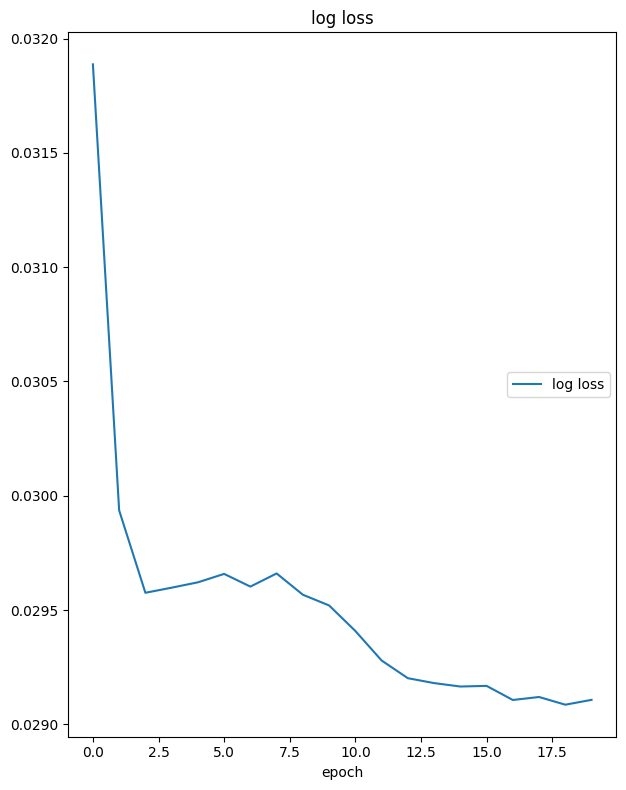

100%|██████████| 20/20 [08:00<00:00, 24.03s/it]

log loss
	log loss         	 (min:    0.029, max:    0.032, cur:    0.029)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# input_size = 418
# n_hidden = 128                         
n_layers = 1
# embedding_dim = input_size
# n_unique_words = len(words_dataset.unique_words)
batch_size = 128
sequence_length = 1
channels = 1

lr = 5e-3
momentum = 0.5
n_epochs = 20

model = ConvLSTM(input_dim=channels,  #here, the inputdim  should be sequence length
                 hidden_dim=16,
                 kernel_size=(3, 3),
                 num_layers=1,
                 batch_first=True,
                 bias=True,
                 return_all_layers=False).to(device)

print(f'The model has {count_trainable_parameters(model):,} trainable parameters')

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# train_1D_ = train_1D.astype('double')
words_dataset = MyDataset(train, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)  

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in tqdm(range(n_epochs)):
    logs = {}
    print(criterion)
    train_loss = train_lstm_gen(model, optimizer, criterion, words_dataloader)
    # res = predict_lstm_gen(test_dataset, lstm_gen, next_words=len(test_dataset))
    # mserror = mse(res,pca_test[4:])

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    # logs['val_' + 'log loss'] = mserror 
    liveloss.update(logs)
    liveloss.draw()

    # if (epoch > 5) and ( (epoch+1) % 5) == 0:
    #   torch.save(lstm_gen.state_dict(), f'/content/gdrive/MyDrive/BigData/assessment/modelpca_{epoch+1}_3_5')

In [43]:
test.shape

(5000, 256, 256)

In [35]:
a,_ = test_dataset[i]

torch.Size([1, 1, 256, 256])


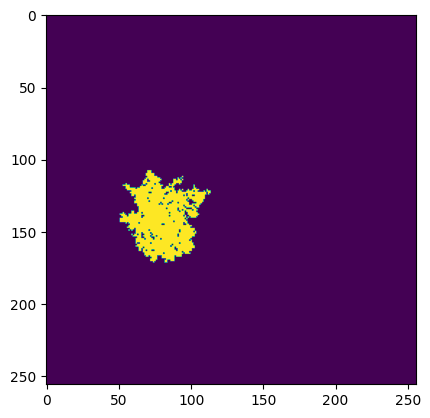

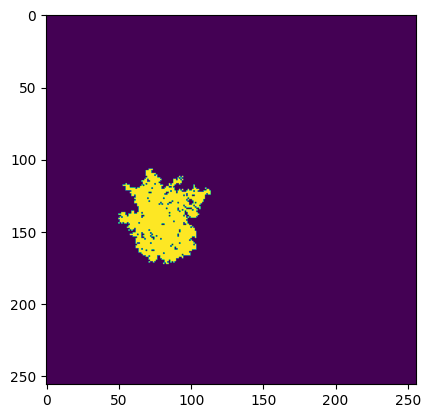

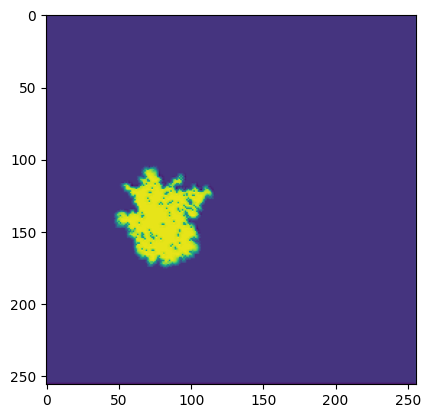

In [44]:
i=3040
img,tar = test[i],test[i+1]
# time = 4000
plt.imshow(img)
a,_ = test_dataset[i]
a = a.to(device)
_,pre = model(a[None,:])
print(pre.shape)
plt.show()
plt.imshow(tar)
plt.show()
pre=pre.cpu().detach().numpy()
plt.imshow(pre.reshape(256,256))

In [46]:
torch.save(model,'/content/gdrive/MyDrive/BigData/assessment/Conv2DLstm_1' )

mse_phy=0.009423211168306352
5.1128904170914735 %


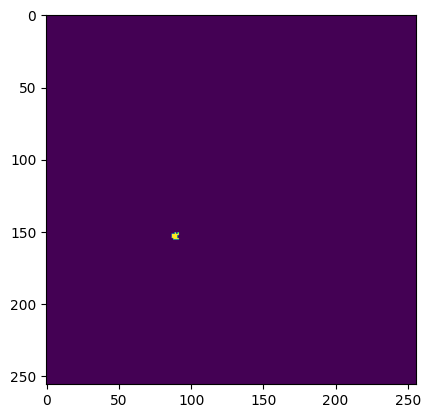

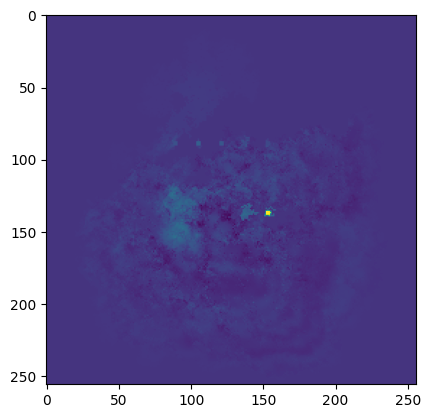

In [ ]:
pred_pcaspace = predict_lstm_gen(test_dataset, lstm_gen, next_words=len(test_dataset))
pred_pcaphy = pca.inverse_transform(pred_pcaspace)
mse_phy = mse(pred_pcaphy,test_1D[4:])
print(f'{mse_phy=}')
print(mse_phy/np.std(test_1D)*100,'%')
time = 4000
plt.imshow(test_1D[time].reshape(256,256))
plt.show()
plt.imshow(pred_pcaphy[time+4].reshape(256,256))

In [ ]:
device

device(type='cuda')

We can see that the LSTM generates more coherent text, and jokes that are more funny too!

In [ ]:
# dataset with split per 100
class MyDataset(TensorDataset):
    def __init__(self, data,sequence_length=4):
        self.data = data.astype('float64')
        self.sequence_length = sequence_length

    def __getitem__(self, idx):
        ind = ((idx+1) // (100-self.sequence_length))*(self.sequence_length) + idx
        sample_input = torch.tensor(self.data[ind:ind+self.sequence_length])       # get a sample input sequence
        sample_output = torch.tensor(self.data[ind+1:ind+self.sequence_length+1])  # get a sample output sequence

        # return sample_input.type('torch.DoubleTensor'), sample_output.type('torch.DoubleTensor')
        return sample_input, sample_output
    
    def __len__(self):
        return len(self.data) - 125 * (self.sequence_length) - self.sequence_length